In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from new_aeb_gplvm import *
from utils.data_generator import DataGenerator
from utils.myutils import Utils
from tqdm import trange
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt

utils = Utils()
import time

In [3]:
def create_dataframe(experiment):
    datagenerator = DataGenerator()

    noise_type = (
        None if experiment["noise_type"] == "normal" else experiment["noise_type"]
    )  # irrelevant,duplicated
    anomaly_type = (
        None if experiment["anomaly_type"] == "normal" else experiment["anomaly_type"]
    )  # cluster,global,local,dependency

    datagenerator.dataset = experiment["dataset"]
    data = datagenerator.generator(
        la=1.00,
        realistic_synthetic_mode=anomaly_type,
        noise_type=noise_type,
        noise_ratio=float(experiment["noise_ratio"]),
        stdscale=True,
        minmax=False,
    )

    Y_train = torch.tensor(data["X_train"], dtype=torch.float32)
    Y_test = torch.tensor(data["X_test"], dtype=torch.float32)
    lb_train = torch.tensor(data["y_train"], dtype=torch.float32)
    lb_test = torch.tensor(data["y_test"], dtype=torch.float32)

    return Y_train, Y_test, lb_train, lb_test

In [17]:
EXPERIMENTS_FILE = "experiments/complete/000_datasets_01_47_normal_03_best.json"
with open(EXPERIMENTS_FILE) as file:
    experiments = json.load(file)
df = pd.DataFrame(experiments)
df = df[df.dataset != "34_smtp"]
experiments = df.to_dict(orient="records")

In [9]:
df[['dataset','val_auc_roc']].head(15)

,dataset,val_auc_roc
0,01_ALOI,0.602816
1,02_annthyroid,0.741543
2,03_backdoor,0.857240
3,04_breastw,0.988913
4,05_campaign,0.754987
5,06_cardio,0.966179
6,07_Cardiotocography,0.769252
7,08_celeba,0.884948
8,09_census,0.682318
9,10_cover,0.976110


In [38]:
success_experiments = []
failed_experiments = []
for experiment in tqdm_notebook(experiments[0:1]):
    Y_train, Y_test, lb_train, lb_test = create_dataframe(experiment)
    Y_val, Y_test, lb_val, lb_test = train_test_split(
        Y_test, lb_test, test_size=0.50, random_state=42
    )

    n_train = len(Y_train)
    data_dim = Y_train.shape[1]
    kernel = experiment["kernel"]
    latent_dim = int(experiment["latent_dim"])
    nn_layers = tuple(map(int, experiment["layers"].split(",")))
    n_inducing = int(experiment["n_inducing"])
    n_epochs = int(experiment["n_epochs"])
    lr = float(experiment["learning_rate"])
    batch_size = int(experiment["batch_size"])
    dataset = experiment['dataset']

    # print(experiment)

    try:
        gplvm = AD_GPLVM(
            latent_dim, n_inducing, n_epochs, nn_layers, lr, batch_size, kernel
        )

        # Fitting the Model
        train_start_time = time.time()
        gplvm.fit(Y_train)
        train_end_time = time.time()

        # Validating the Model
        val = []
        for i in range(100):
            score = gplvm.predict_score(Y_val)
            val.append(score)
        validation_score = np.mean(val, axis=0)
        # validation_score = gplvm.calculate_train_elbo(Y_train_normal)

        # Results
        pred_start_time = time.time()
        test_score = gplvm.predict_score(Y_test)
        pred_end_time = time.time()

        # Save Metrics
        metrics = utils.metric(y_true=lb_val, y_score=validation_score)
        validation_metrics = utils.metric(y_true=lb_test, y_score=test_score)
        experiment["negative_elbo"] = validation_score.sum()  # validation_score.sum()
        experiment["train_loss_curve"] = gplvm.loss_list
        experiment["val_auc_roc"] = validation_metrics["aucroc"]
        experiment["val_auc_pr"] = validation_metrics["aucpr"]
        experiment["test_auc_roc"] = metrics["aucroc"]
        experiment["test_auc_pr"] = metrics["aucpr"]
        experiment["training_time"] = train_end_time - train_start_time
        experiment["inference_time"] = pred_end_time - pred_start_time

        # Reconstrucao
        Y_val_recon, Y_val_recon_covar = gplvm.model.reconstruct_y(Y_val)
        experiment["val_reconstruct_error"] = float(utils.rmse(Y_val, Y_val_recon.T))
        
        pd.Series(experiment).to_json(f"experiments/complete/results/contaminated/{dataset}.json")

        #utils.save_experiment(experiment)

    except Exception as error:
        print("An exception occurred:", error)
        experiment["test_auc_roc"] = 0.0
        experiment["test_auc_pr"] = 0.0
        pd.Series(experiment).to_json(f"experiments/complete/results/contaminated/{dataset}.json")
        #utils.save_experiment(experiment)

/tmp/ipykernel_118/3910820380.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for experiment in tqdm_notebook(experiments[0:1]):


  0%|          | 0/1 [00:00<?, ?it/s]

subsampling for dataset 01_ALOI...


KeyboardInterrupt: 

In [13]:
df_contamined = utils.read_json_from_folder("experiments/complete/results/contaminated/")

In [16]:
df_contamined.to_json("000_datasets_01_47_contamined_01_results.json", orient = "records")

In [28]:
(df["test_auc_roc"] - df_contamined["test_auc_roc"]).median()

0.041412210299999974

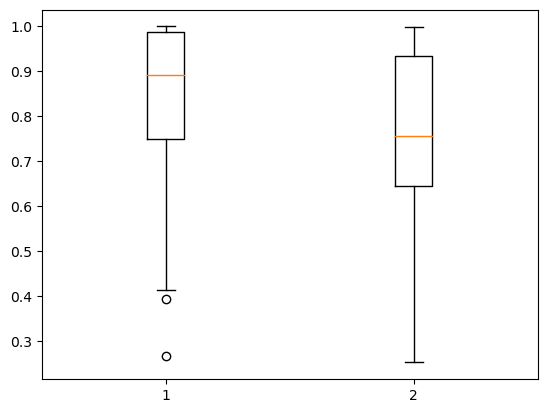

In [33]:
plt.boxplot([df["test_auc_roc"],df_contamined["test_auc_roc"]])
None

In [35]:
df_contamined

,dataset,n_samples,n_features,n_anomaly,pct_anomaly,domain,kernel,batch_size,learning_rate,loss,...,n_epochs,negative_elbo,train_loss_curve,val_auc_roc,val_auc_pr,test_auc_roc,test_auc_pr,training_time,inference_time,val_reconstruct_error
0,01_ALOI,49534,27,1508,3.04,Image,matern_3_2,128,0.01,normal,...,1000,39.311615,"[60.8537597656, 47.6781692505, 49.2098236084, ...",0.577597,0.039178,0.485394,0.037248,55.449657,0.025620,0.856306
1,02_annthyroid,7200,6,534,7.42,Healthcare,matern_1_2,128,0.01,normal,...,1000,8.604567,"[14.1528587341, 12.5763120651, 12.6032037735, ...",0.673509,0.245789,0.648040,0.170509,17.445722,0.007444,0.850520
2,03_backdoor,95329,196,2329,2.44,Network,matern_3_2,128,0.01,normal,...,1000,187.536530,"[308.6104736328, 356.016204834, 309.1676635742...",0.856804,0.316322,0.822818,0.267721,68.609171,0.097224,0.459582
3,04_breastw,683,9,239,34.99,Healthcare,rbf,128,0.01,normal,...,1000,9.761041,"[17.4938049316, 17.6063613892, 16.2380943298, ...",0.977825,0.958013,0.971100,0.917740,10.520657,0.004159,0.548035
4,05_campaign,41188,62,4640,11.27,Finance,rbf,128,0.01,normal,...,1000,90.578758,"[129.4533691406, 123.3213577271, 118.097984314...",0.734136,0.270184,0.710814,0.229155,38.988440,0.034767,0.826358
5,06_cardio,1831,21,176,9.61,Healthcare,matern_3_2,128,0.01,normal,...,1000,30.609411,"[52.8825149536, 47.1437721252, 48.8612823486, ...",0.910507,0.560606,0.890561,0.384064,19.229731,0.009530,0.706550
6,07_Cardiotocography,2114,21,466,22.04,Healthcare,matern_3_2,128,0.01,normal,...,1000,27.116854,"[53.6738891602, 43.5708198547, 46.1714935303, ...",0.630420,0.394342,0.679542,0.398169,15.040034,0.006093,0.638984
7,08_celeba,202599,39,4547,2.24,Image,matern_1_2,128,0.01,normal,...,1000,55.917904,"[92.8928375244, 80.7588424683, 82.0813140869, ...",0.872161,0.130533,0.784912,0.190737,73.929406,0.024324,0.911903
8,09_census,299285,500,18568,6.20,Sociology,matern_1_2,128,0.01,normal,...,1000,761.541992,"[959.0897827148, 1019.5137329102, 1002.2402954...",0.673036,0.089468,0.649509,0.089464,192.081827,0.270468,1.011401
9,10_cover,286048,10,2747,0.96,Botany,rbf,128,0.01,normal,...,1000,13.975452,"[20.7080059052, 20.6384010315, 20.4970016479, ...",0.938504,0.137579,0.934084,0.067858,20.352898,0.012640,0.785027
